# Blazar Synchrotron Tool (BlaST) V2

_BlaST_ is an ensemble of neural networks estimating the synchroton peak's frequency and flux of a
blazar including a prediction interval given its spectral energy distribution as outputted by the
VOUBlazar tool. The goal of this notebook is to train the networks. Their respective hyperparameter
tuning already happened and won't be shown here.

As a special quirk the tool uses double ensemble: Bagging is applied to create different subset to train. For each subset an ensemble is trained to improve the prediction as stated by Blundell et. al. 2017.
Separate ensembles are trained for both the frequency and flux estimate.

In the end the bagging allows to reapply the model on the out of bag data to hopefully increase the quality of the dataset. The final tool is expected to be applied on unseen data and thus uses all available ensembles.

## Differences to V1

This notebook is for the second version of the model.
The following lists some differences to the first version:

- **New data set**  
The data set has been refined resulting in a new set independent of the previous
one. This one now also includes labels for the flux.
- **Flux estimate**  
Biggest difference is the estimation of the synchrotron peak's flux by an
independent ensemble of neural networks.
- **Weighted loss**  
In V1 we oversampled the dataset based on the label density to reduce bias.
Since we now have two labels with different densities this was no longer
possible. Instead, the training loss was weighted by the inverse label
density respectively for each label. Later tests not only indicated that this
method not only took care of the bias, but it also appeared to improve performance.
We still augment the data set by creating copies with deleted bins.
- **Save models in ONNX format**  
Previously, the tool needed pytorch installed, which is quite large. We moved to
ONNX runtime to make the installation slimmer.

## Data Preparation

We start by parsing the data set. It is simply a zip containing SEDs as produced by the
VOUBlazar tool each looking like the following:  
(_Note_: To comply with GitHubs file size limit, the zip was compressed using lzma.
Some file explorer may have trouble decompressing it.)

```
   1  matched source   78.45462  -21.98780  99  *****
 Frequency     nufnu     nufnu unc.  nufnu unc. start time   end time   Flag  Catalog          Reference
    Hz       erg/cm2/s     upper       lower        MJD         MJD   
---------------------------------------------------------------------------------------------------------------------------
 1.400E+09   9.064E-15   9.335E-15   8.792E-15  55000.0000  55000.0000   Det  NVSS             Condon et al. 1998, AJ, 115, 1693                                                           
 8.870E+08   5.606E-15   6.003E-15   5.208E-15  55000.0000  55000.0000   Det  RACS             Hale et al. 2021, PASA, 38, e058
```

Thus, we have 4 lines of header until the actual data begins. After that we are only
interested in the first 4 entries per row as well as the flag indicating whether the
row is a detection or upper limit. The latter are ignored, as we calculate binned
flux means.  
Errors are given for each direction separately, but we prefer a symmetric one.
We use the mean squared error instead.

Next, we need the target values, i.e. the synchrotron peak's frequency and flux.
They are stored in the filename (as it was determined by hand).
Consider an example file:
```
12.2_-12.5_78.45462_-21.98780.txt
```
They are of the format  
_freq_\__flux_\__ra_\__dec_.txt  
i.e., first frequency and flux, followed by the source position noted by its
right ascension and declination.

Next, we have to sanitize the data. We encountered the following problems:
- Zero frequency
- Negative or zero flux
- Flux outside upper/lower bound
We simply ignore such entries.

Finally, the data is binned. This is necessary since the neural network is a simple
fully connected network (FCN) and thus expects a constant sized input. Remember,
that we will train independent ensembles for each target. While each ensemble
share the binning, they may ignore specific bins if they are strongly biased
(i.e. bin only populated for specific target values). This is necessary as the
neural network would exploit such bias and thus fail to generalize to unseen data.
The actual bin edges were determined beforehand such that they are approximately
equally densely filled.

In [1]:
import numpy as np
from io import TextIOWrapper
from os.path import basename, splitext
from zipfile import ZipFile

# seed rng to make data preparation deterministic
rng = np.random.default_rng(0xC0FFEE)

data = []
label = []
pos = []
seds = ZipFile("seds.zip")

bins = np.loadtxt("blast/bins.txt", skiprows=1)
ranges = bins[:,:2]
n_bins = len(ranges)
freq_inc = bins[:,2].astype(np.bool_)
flux_inc = bins[:,3].astype(np.bool_)

def getlabel(path):
    nu_peak, nufnu_peak = basename(path).split("_")[:2]
    return float(nu_peak), float(nufnu_peak)
def getpos(filename):
    name = splitext(basename(filename))[0]
    parts = name.split('_')
    return float(parts[2]) ,float(parts[3])
def sanitize(data):
    data = np.delete(data, data[:,0] <= 0, axis=0)
    data = np.delete(data, data[:,1] <= 0, axis=0)
    return data
def bin_data(data):
    result = []
    for sed in data:
        line = []
        for bin in ranges:
            inside = (sed[:,0] >= bin[0]) & (sed[:,0] <= bin[1])
            flux = sed[inside][:,1]
            line.append(np.mean(flux) if len(flux) > 0 else 0.0)
        result.append(line)
    return np.array(result)
def loadfile(file):
    _data = []
    for line in file.readlines()[4:]:
        # skip whitespace
        if line.isspace(): continue
        entries = line.split()
        # skip upper limits
        if entries[6] != "Det": continue

        freq = float(entries[0])
        nufnu = float(entries[1])
        upper = float(entries[2])
        lower = float(entries[3])
        # sanity check
        if not np.isfinite(freq) or not np.isfinite(nufnu):
            continue
        if (nufnu > upper or nufnu < lower) and upper != 0.0 and lower != 0.0:
            continue

        _data.append([freq, nufnu])
    _data = np.array(_data)
    _data = sanitize(_data)
    _data = np.log10(_data)
    assert(np.isfinite(_data).all())
    return _data

i = 1
for filename in seds.namelist():
    print(f"{i:>4}: {filename:<80}", end='\r')
    i += 1
    # skip folders
    if filename[-1] == "/": continue
    label.append(getlabel(filename))
    pos.append(getpos(filename))
    with TextIOWrapper(seds.open(filename)) as file:
        data.append(loadfile(file))
print("\n")
data = bin_data(data)
label = np.array(label)
pos = np.array(pos)

print(f"{len(data)} data entries loaded")
print(f"{len(label)} labels loaded")
print(f"data example: {data[0]}")
print(f"label (nu_peak): {label[0]}")
print(f"position: {pos[0]}")

3344: 19.0_-11.7_50.23492_4.41344.txt                                                 

3344 data entries loaded
3344 labels loaded
data example: [  0.         -15.47626386 -15.06631029 -14.67670567 -13.9262049
 -13.27345258 -12.72557731 -12.08682539 -11.85727324 -11.82556449
 -11.73072061 -12.31197062 -12.52714632 -12.2141967  -12.16485907
 -12.11472558 -12.04966933   0.         -12.61931481 -12.50537781
 -12.5229016  -12.39925601 -12.31112632   0.           0.
   0.           0.           0.           0.           0.        ]
label (nu_peak): [ 12.1 -11.7]
position: [101.63346  44.85461]


Next step is to create the bagging. There are about 3,500 samples in the data
set, thus each bag gets roughly 700 samples.

In [2]:
# we partition the seds by shuffling indices and take n equal sized parts
indices = np.arange(len(label))
rng.shuffle(indices)
bag_size = int(np.ceil(len(label) / 5))
# create bags
bagged_idx = [indices[bag_size*i:bag_size*(i+1)] for i in range(5)]
bagged_data = [data[bag] for bag in bagged_idx]
bagged_label = [label[bag] for bag in bagged_idx]
for i in range(5):
    print(f'Size of bag {i}: {len(bagged_label[i])}')

Size of bag 0: 669
Size of bag 1: 669
Size of bag 2: 669
Size of bag 3: 669
Size of bag 4: 668


Save position with bag index. We need it later for automatic checking whether a
SED was used for training.

In [3]:
bag_idx = np.empty((len(label),3))
for i in range(5):
    bag_idx[bag_size*i: bag_size*(i+1),:2] = pos[indices[bag_size*i: bag_size*(i+1)]]
    bag_idx[bag_size*i: bag_size*(i+1), 2] = i

np.save("blast/bag_index.npy", bag_idx)

### Augmentation

We can't use the same augmentation process as before, as we now have two labels.
Instead, handle the imbalance in the training and here only do augmentation.

We augment by creating a copy of the set and randomly delete bins from it. The
bins to delete are chosen based on the frequency of them being non-empty.
Sampling happens with replacement and are not constrained on the bins being
filled. This effectively results in a random number of bins actually being
deleted.

The augmentation happens after the bagging to ensure a roughly equal amount of
unaugmented data in each bag.

In [4]:
def augment(data, label, dels, min_bins=8):
    # calculate prob of bins being deleted
    bin_weights = (data != 0.0).sum(0).astype(np.float64)
    bin_weights /= bin_weights.sum()

    # include original data
    new_data = [data.copy()]
    new_label = [label.copy()]
    # augment data
    for max_dels in dels:
        # create local copy to alter
        _data = data.copy()
        _label = label.copy()
        # randomly delete bins (set to zero)
        i_bin = rng.choice(n_bins, max_dels * len(_data), replace=True, p=bin_weights)
        i_set = np.arange(len(_data)).repeat(max_dels)
        _data[i_set, i_bin] = 0.0
        sizes = (_data != 0.0).sum(1)
        # remove seds with less than min_bins bins filled
        select = np.argwhere(sizes < min_bins)
        _data = np.delete(_data, select, axis=0)
        _label = np.delete(_label, select, axis=0)
        # add augmented set to list
        new_data.append(_data)
        new_label.append(_label)
    
    # concatenate augmented sets and return
    new_data = np.concatenate(new_data)
    new_label = np.concatenate(new_label)
    return new_data, new_label

In [5]:
dels = [7, 12, 17, 22, 27]
augmented = [augment(*b, dels) for b in zip(bagged_data, bagged_label)]

total_augmented = 0
print("Augmented bag size")
for i in range(len(augmented)):
    n = len(augmented[i][0])
    total_augmented += n
    print(f"Bag {i}: {n}")
print(f"\nTotal augmented set size: {total_augmented}")

Augmented bag size
Bag 0: 3488
Bag 1: 3516
Bag 2: 3468
Bag 3: 3505
Bag 4: 3528

Total augmented set size: 17505


## Data Loading

Next step is to make the data available for training.

In [ ]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
print(torch.__version__)

import lightning as L
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split

To improve the performance we standardize the input per bin and per label.
We use the whole augmented data set for that.

For calculating the mean and variance of each bin, we ignore empty ones.
After standardizing, empty bins gets pushed to large (in absolute terms) values.
We reassign them a value of 0.0 to achieve the wanted unit variance making the
value 0.0 ambiguous (either non-empty with mean flux or empty bin). To resolve
this we add a binary mask where 1.0 indicates a non-empty and 0.0 an empty bin.

In [7]:
_data_aug_complete = np.concatenate([a[0] for a in augmented])
_label_aug_complete = np.concatenate([a[1] for a in augmented])

# calculate scaling
bin_mean = np.mean(_data_aug_complete, axis=0, where=(_data_aug_complete != 0.0))
bin_scale = np.std(_data_aug_complete, axis=0, where=(_data_aug_complete != 0.0))
label_mean = np.mean(_label_aug_complete, axis=0)
label_scale = np.std(_label_aug_complete, axis=0)

In [8]:
# save scaling
np.savez("blast/scaling.npz",
    bin_mean=bin_mean,
    bin_scale=bin_scale,
    label_mean=label_mean,
    label_scale=label_scale,
)

The actual magic of loading the data to the device (either GPU or CPU) is handled
by `pytorch_lightning`'s `LightningDataModule`.

Inside the data module we'll also calculate the label weights we need to take
care of the imbalance in the data set.

In [9]:
class DataModule(L.LightningDataModule):
    def __init__(self, bag, label_idx, bin_mask):
        super().__init__()

        # setting up the 5-fold cross validation:
        # the data from all 4 bags except the one which is specified with the
        # bag variable are concatenated
        _data = np.concatenate([augmented[i][0] for i in range(5) if i != bag])
        # a second array is created which stores whether the bin is empty or not 0/1
        _mask = (_data != 0.0).astype(float)
        _label = np.concatenate([augmented[i][1] for i in range(5) if i != bag])
        # scale data
        _data = (_data - bin_mean) / bin_scale * _mask
        _label = (_label - label_mean) / label_scale
        _label = _label[:,label_idx]
        # weights for imbalance correction
        _weight = 1.0 / gaussian_kde(_label)(_label)
        _weight /= _weight.max()
        # mask bins
        _data = _data[:,bin_mask]
        _mask = _mask[:,bin_mask]

        # the train_test_split method from sklearn will split _data, _mask,
        # _label each into a training set and a validation set
        # The splitting will be random, such that the val_data will include 1.5k
        # out of the roughly 14k seds
        self.train_data, self.val_data = train_test_split(_data, test_size=1500, random_state=42)
        self.train_mask, self.val_mask = train_test_split(_mask, test_size=1500, random_state=42)
        self.train_label, self.val_label = train_test_split(_label, test_size=1500, random_state=42)
        self.train_weight, self.val_weight = train_test_split(_weight, test_size=1500, random_state=42)

    def setup(self, stage=None):
        self.train_set = TensorDataset(
            torch.tensor(np.concatenate(
                (self.train_data, self.train_mask), axis=1
            ), dtype=torch.float),
            torch.tensor(self.train_label, dtype=torch.float),
            torch.tensor(self.train_weight, dtype=torch.float)
        )
        self.val_set = TensorDataset(
            torch.tensor(np.concatenate(
                (self.val_data, self.val_mask), axis=1
            ), dtype=torch.float),
            torch.tensor(self.val_label, dtype=torch.float),
            torch.tensor(self.val_weight, dtype=torch.float)
        )

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=96, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=96, shuffle=False)

In [10]:
class FreqDataModule(DataModule):
    def __init__(self, bag):
        super().__init__(bag, 0, freq_inc)

class FluxDataModule(DataModule):
    def __init__(self, bag):
        super().__init__(bag, 1, flux_inc)

## Model

Next up is the model. Once again, the architecture has already been tuned.

In [11]:
class Model(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.lr = config['lr']
        self.weight_decay = config['weight_decay']
        self.model = nn.Sequential(
            nn.Linear(config['n_bins'] * 2, config['hidden1']),
            nn.BatchNorm1d(config['hidden1']),
            nn.Dropout(config['drop1']),
            nn.ReLU(),
            nn.Linear(config['hidden1'], config['hidden2']),
            nn.BatchNorm1d(config['hidden2']),
            nn.Dropout(config['drop2']),
            nn.ReLU(),
            nn.Linear(config['hidden2'], config['hidden3']),
            nn.BatchNorm1d(config['hidden3']),
            nn.Dropout(config['drop3']),
            nn.ReLU(),
            nn.Linear(config['hidden3'], config['hidden4']),
            nn.BatchNorm1d(config['hidden4']),
            nn.Dropout(config['drop4']),
            nn.ReLU(),
            nn.Linear(config['hidden4'], 2)
        )
    
    def forward(self, x):
        out = self.model(x.float())
        mean, var = torch.unbind(out, dim=1)
        var = F.softplus(var)
        return mean, var
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=3)
        return {
            'optimizer' : optim,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }
    
    def training_step(self, batch, batch_idx):
        x, y, w = batch
        y, w = y.squeeze(), w.squeeze()
        mean, var = self(x)
        # gaussian log likelihood: -2ln[p(x,y)]; weighted by label
        llh = torch.log(var) + (y - mean)**2/var
        loss = torch.mean(torch.unsqueeze(w * llh, 0))
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        mse = F.mse_loss(mean.detach(), y)
        self.log("train_mse", mse, on_step=False, on_epoch=True)
        self.log("train_mean_var", torch.mean(var.detach()), on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, w = batch
        y, w = y.squeeze(), w.squeeze()
        mean, var = self(x)
        # gaussian log likelihood: -2ln[p(x,y)]; weighted by label
        llh = torch.log(var) + (y - mean)**2/var
        loss = torch.mean(torch.unsqueeze(w * llh, 0))
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        mse = F.mse_loss(mean.detach(), y)
        self.log("val_mse", mse, on_step=False, on_epoch=True)
        self.log("val_mean_var", torch.mean(var.detach()), on_step=False, on_epoch=True)
        return loss

In [12]:
# configuration for frequency ensemble
freq_config = {
    "n_bins": freq_inc.sum(),
    "lr": 0.0008539506339443158,
    "weight_decay": 2.362783417797096e-05,
    "drop1": 0.21508958785881382,
    "drop2": 0.028523469831487958,
    "drop3": 0.153638748089792,
    "drop4": 0.04254264340374547,
    "hidden1": 227,
    "hidden2": 114,
    "hidden3": 126,
    "hidden4": 71,
}

In [13]:
# configuration for flux ensemble
flux_config = {
    "n_bins": flux_inc.sum(),
    "lr": 0.0003487446516494235,
    "weight_decay": 7.105084414495292e-05,
    "drop1": 0.09280667514561997,
    "drop2": 0.055688866999183795,
    "drop3": 0.1492527033284929,
    "drop4": 0.02274056807086311,
    "hidden1": 251,
    "hidden2": 99,
    "hidden3": 62,
    "hidden4": 75,
}

## Training

Now the model can be trained. We'll train 5 models for each bag and target.
This way we will have later an ensemble of 5 models for out of bag estimates and
even 25 for unseen data.

In [14]:
ensemble_size = 5

def train(name, config, modules):
    for bag in range(len(modules)):
        for i in range(ensemble_size):
            model = Model(config)
            trainer = L.Trainer(
                max_epochs=500,
                logger=TensorBoardLogger("logs/", name=f"{name}_{bag}.{i}"),
                enable_progress_bar=False,
                callbacks=[ModelCheckpoint(
                    dirpath=f"models/{name}/",
                    filename=f"{bag}.{i}_{{epoch}}_{{step}}_{{val_loss:.6f}}",
                    save_top_k=3,
                    monitor="val_loss",
                    mode="min",
                    every_n_epochs=1,
                )]
            )
            trainer.fit(model, modules[bag])

In [ ]:
# train frequency ensemble
freq_data_modules = [FreqDataModule(i) for i in range(5)]
train("freq", freq_config, freq_data_modules)

In [ ]:
# train flux ensemble
flux_data_modules = [FluxDataModule(i) for i in range(5)]
train("flux", flux_config, flux_data_modules)

Since we saved checkpoints, we now have to export the models.

In [20]:
from pathlib import Path

def export_onnx(model, path, example):
    for f in path.glob("./*.ckpt"):
        m = model.load_from_checkpoint(f)
        torch.onnx.export(
            m,
            example.to(device=m.device),
            str(path / f"{f.stem[:3]}.onnx"),
            verbose=False,
            input_names=["bins"],
            output_names=["mean", "var"],
            dynamic_axes={
                "bins": { 0: "batch" },
                "mean": { 0: "batch" },
                "var": { 0: "batch" }
            },
            export_params=True
        )

In [ ]:
flux_example = next(iter(flux_data_modules[0].val_dataloader()))[0]
freq_example = next(iter(freq_data_modules[0].val_dataloader()))[0]

export_onnx(Model, flux_config, Path("./models/flux/"), flux_example)
export_onnx(Model, freq_config, Path("./models/freq/"), freq_example)

If you retrain the models, don't forget to copy the `.onnx` files into the blast
folder.

## Evaluation

Now that our models are done, let's evaluate them.

In [22]:
from blast import PeakFluxEstimator, PeakFrequencyEstimator

freq_estimator = PeakFrequencyEstimator()
flux_estimator = PeakFluxEstimator()

freq_truth = label[:,0]
freq_est = np.zeros_like(freq_truth)
freq_err = np.zeros_like(freq_truth)

flux_truth = label[:,1]
flux_est = np.zeros_like(flux_truth)
flux_err = np.zeros_like(flux_truth)

# estimate out of bag
for i, bag in enumerate(bagged_idx):
    _data = data[bag]

    freq_est[bag], freq_err[bag] = freq_estimator(_data, i)
    flux_est[bag], flux_err[bag] = flux_estimator(_data, i)

In [23]:
def int_score(est, err, true):
    return 2.0 * err + 0.341345 * err * (np.abs(true - est) > err).astype(np.float32)

def print_metrics(est, err, true):
    print(f'Median Absolute Error: {np.median(np.abs(true-est)):.3f}')
    print(f'         25% quantile: {np.quantile(np.abs(true-est),0.25):.3f}')
    print(f'         75% quantile: {np.quantile(np.abs(true-est),0.75):.3f}')
    print('')
    print(f'Median PI Width: {np.median(2*err):.3f}')
    print(f'   25% quantile: {np.quantile(2*err, 0.25):.3f}')
    print(f'   75% quantile: {np.quantile(2*err, 0.75):.3f}')
    score = int_score(est, err, true)
    print('')
    print(f'Mean Interval Score: {np.mean(score):.3f}')
    print(f'       25% quantile: {np.quantile(score, 0.25):.3f}')
    print(f'       75% quantile: {np.quantile(score, 0.75):.3f}')

print("Frequency:")
print("==============================")
print_metrics(freq_est, freq_err, label[:,0])
print("\nFlux:")
print("==============================")
print_metrics(flux_est, flux_err, label[:,1])

Frequency:
Median Absolute Error: 0.163
         25% quantile: 0.075
         75% quantile: 0.314

Median PI Width: 1.267
   25% quantile: 1.009
   75% quantile: 1.625

Mean Interval Score: 1.400
       25% quantile: 1.010
       75% quantile: 1.636

Flux:
Median Absolute Error: 0.104
         25% quantile: 0.049
         75% quantile: 0.186

Median PI Width: 1.087
   25% quantile: 0.971
   75% quantile: 1.198

Mean Interval Score: 1.088
       25% quantile: 0.972
       75% quantile: 1.199


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic
from scipy.interpolate import splev, splrep

sns.set_theme()
hist_cmap = sns.color_palette("PuBu", as_cmap=True)

In [25]:
def plot_pi(estimate, error, truth):
    p = (np.min(label), np.max(label))

    plt.figure(figsize=(8,6))
    _, _label_edges, *_ = plt.hist2d(truth, estimate, bins=30, cmap=hist_cmap)
    _bins = (_label_edges[:-1] + _label_edges[1:]) / 2
    _median, *_ = binned_statistic(truth, estimate, statistic='median', bins=_label_edges)
    _lower, *_ = binned_statistic(truth, estimate, bins=_label_edges, statistic=lambda x: np.percentile(x, 10))
    _upper, *_ = binned_statistic(truth, estimate, bins=_label_edges, statistic=lambda x: np.percentile(x, 90))
    plt.plot(p, p, color='gray', linewidth=1.35)
    plt.plot(_bins, _median, color='black', linewidth=1.2)
    plt.plot(_bins, _lower, color='black', linestyle='dashed', linewidth=1)
    plt.plot(_bins, _upper, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel('Ground Truth')
    plt.ylabel('Predictions')
    plt.show()

    sort = error.argsort()
    _estimate = estimate[sort]
    _error = error[sort]
    _truth = truth[sort] - _estimate
    N = len(truth)
    _below = (_truth < -_error).sum() / N * 100
    _above = (_truth > _error).sum() / N * 100

    plt.figure(figsize=(8,6))
    plt.fill_between(np.arange(N), _error, -_error)
    plt.scatter(np.arange(N), _truth, s=2.5)
    plt.text(0,2,f'{_above:.2f}%')
    plt.text(0,-2,f'{_below:.2f}%')
    plt.ylabel('Prediction interval with ground truth (centered)')
    plt.xlabel('ordered samples')
    plt.ylim(-3,3)
    plt.show()

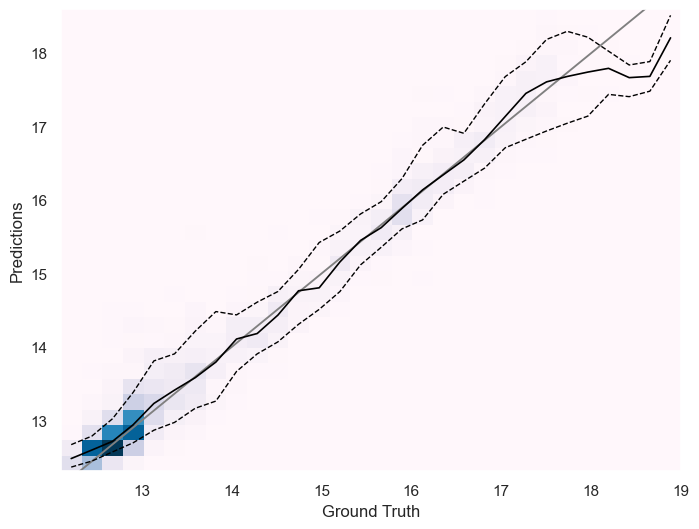

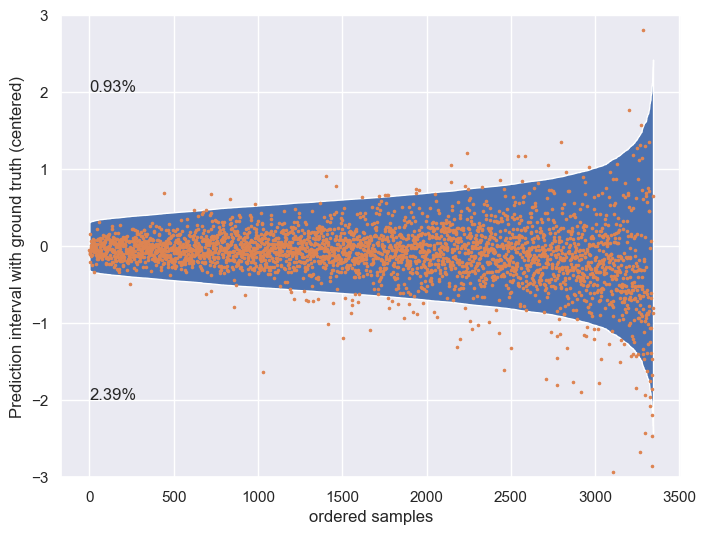

In [26]:
plot_pi(freq_est, freq_err, label[:,0])

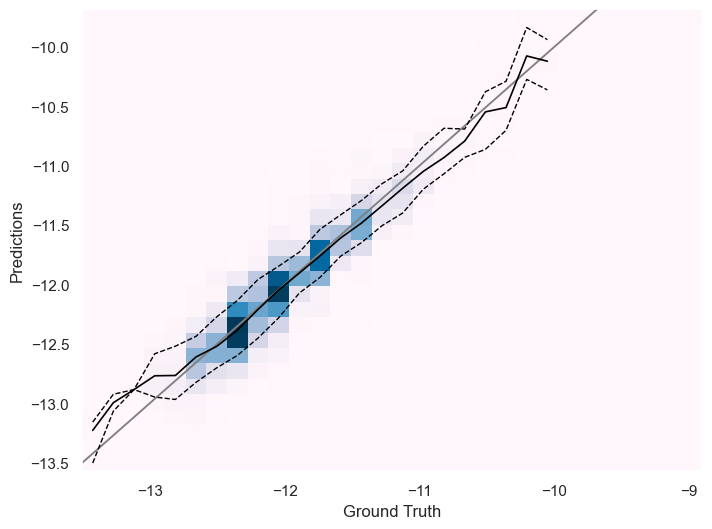

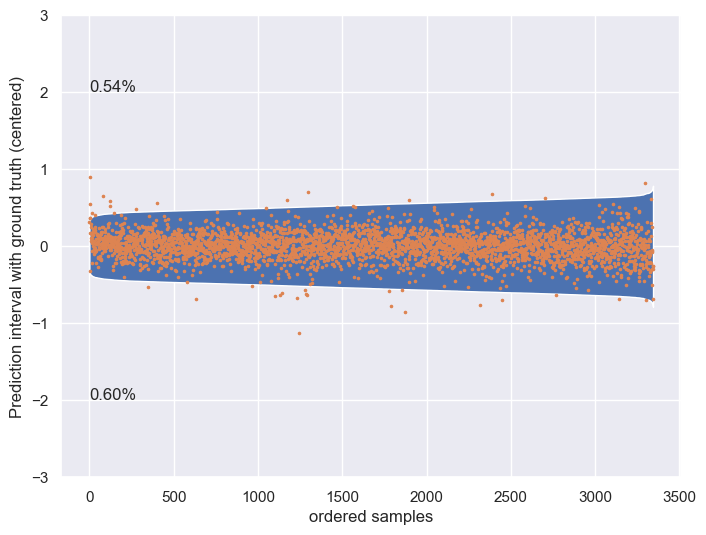

In [27]:
plot_pi(flux_est, flux_err, label[:,1])

In [28]:
def plot_dist(estimate, error, truth, xlabel):
    _min = np.min(truth)
    _max = np.max(truth)
    sample_points = np.arange(_min, _max, 0.25)
    x = np.linspace(_min, _max, 200)
    linewidth = 1.5

    def moving_apply(data, f, width=0.5):
        result = []
        for s in sample_points:
            mask = (truth >= s - width) & (truth <= s + width)
            result.append(f(data[mask]))
        return np.array(result)

    plt.figure(figsize=(8,6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    dense_ax = ax1.twinx()

    sns.kdeplot(truth, cut=0, ax=dense_ax, color='gray', linestyle='dashed', linewidth=1, label="truth density")
    sns.kdeplot(estimate, cut=0, ax=dense_ax, color='black', linestyle='dashed', linewidth=1, label="estimate density")
    dense_ax.grid=False
    dense_ax.set(ylabel=None, yticks=[])
    dense_ax.legend()

    mad = moving_apply(np.abs(truth - estimate), np.median)
    mad = splev(x, splrep(sample_points, mad))

    ax1.plot(x, mad)
    ax1.set_ylabel('Median Absolute Eror')
    ax1.set_xlabel(xlabel)
    y_min = np.floor(np.min(mad)*10)/10
    y_max = np.ceil(np.max(mad)*10)/10
    ax1.set_yticks(np.linspace(y_min,y_max, 6))
    ax1.set_ylim(y_min, y_max)
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.set_axisbelow(True)

    pi = moving_apply(error, np.median)
    pi = splev(x, splrep(sample_points, pi))

    ax2.plot(x, pi, color='C1')
    ax2.set_ylabel('Median PI Width')
    y_min = np.floor(np.min(pi)*10)/10
    y_max = np.ceil(np.max(pi)*10)/10
    ax2.set_yticks(np.linspace(y_min,y_max, 6))
    ax2.set_ylim(y_min, y_max)
    ax2.tick_params(axis='y', labelcolor='C1')
    ax2.set_axisbelow(True)
    ax2.grid(None)

    plt.show()

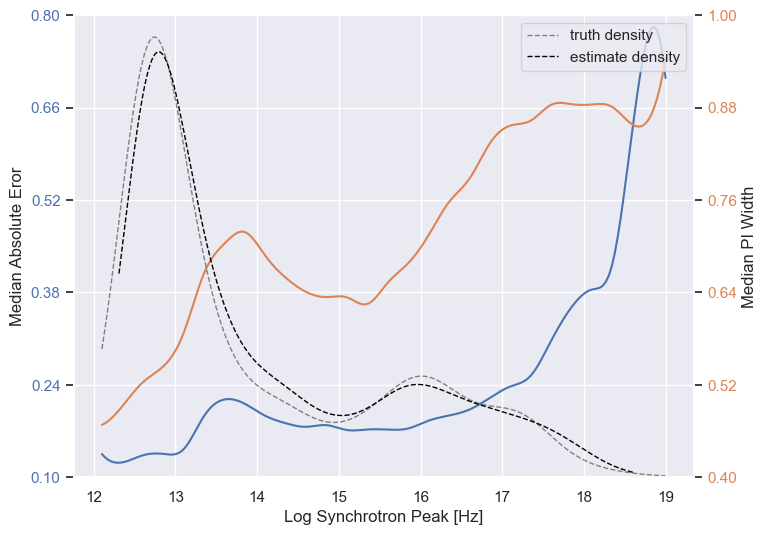

In [29]:
plot_dist(freq_est, freq_err, label[:,0], "Log Synchrotron Peak [Hz]")

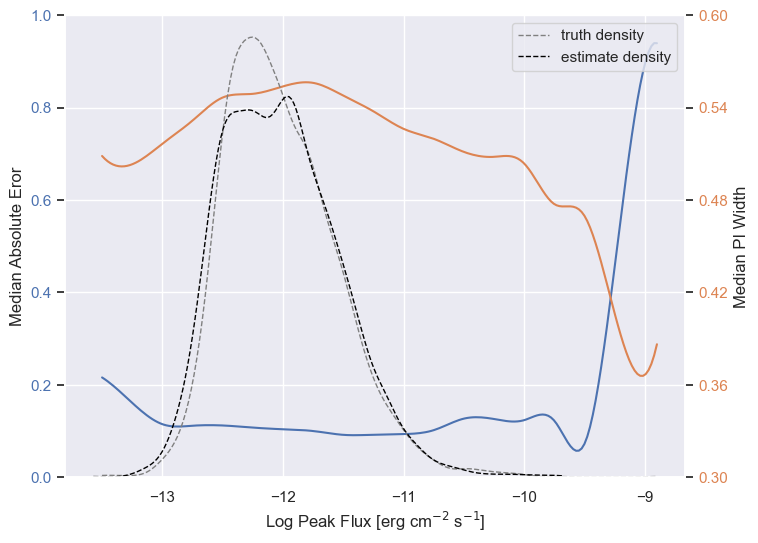

In [30]:
plot_dist(flux_est, flux_err, label[:,1], "Log Peak Flux [erg cm$^{-2}$ s$^{-1}$]")

In [31]:
import scipy.stats

def plot_pi_gauss(est, err, true, pi, tol):
    mask = (err >= (pi - tol)) & (err <= (pi + tol))
    dif = est - true

    plt.figure(figsize=(4,4))
    plt.title(f"$\sigma$ = {pi:.2f}")
    plt.hist(dif[mask], density=True, bins="auto")
    x = np.linspace(-1.5,1.5)
    plt.plot(x, scipy.stats.norm.pdf(x, scale=pi))
    plt.xlim(-1.5,1.5)
    plt.show()

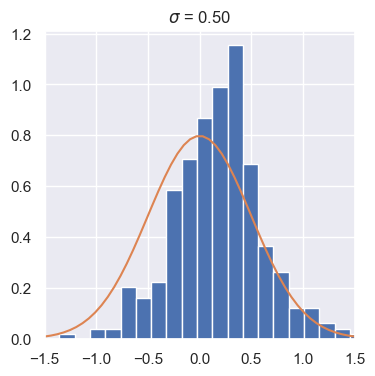

In [33]:
plot_pi_gauss(freq_est, freq_err / 1.96, label[:,0], 0.5, 0.05)

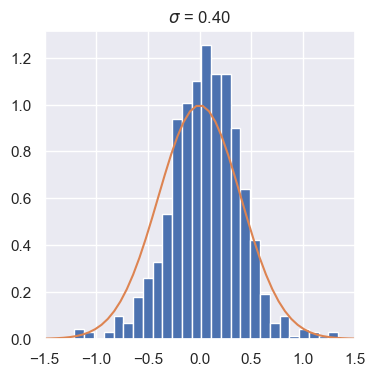

In [34]:
plot_pi_gauss(freq_est, freq_err / 1.96, label[:,0], 0.4, 0.05)

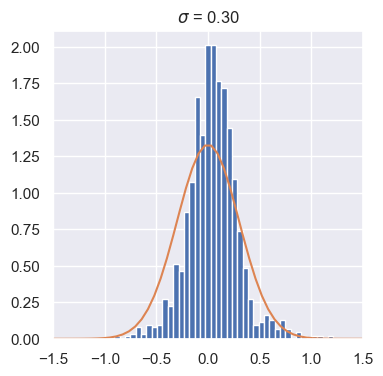

In [35]:
plot_pi_gauss(freq_est, freq_err / 1.96, label[:,0], 0.3, 0.05)

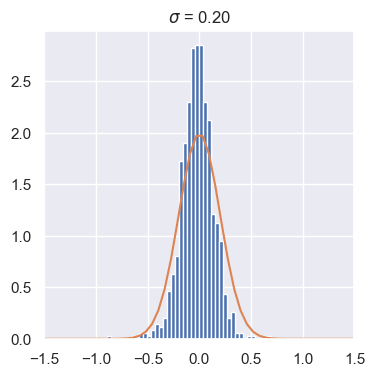

In [36]:
plot_pi_gauss(flux_est, flux_err / 1.96, label[:,1], 0.2, 0.05)